In [1]:
import pandas as pd
import numpy as np
import re
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Dense, Dropout, BatchNormalization,Input,Bidirectional,LSTM
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt
import joblib
from tensorflow.keras.models import load_model

# Data Preprocessing

In [165]:
# Membaca dataset yang telah digabungkan
file_path = 'jamid_musytaq_vn_with_root.csv'
df = pd.read_csv(file_path, encoding='utf-8')


In [166]:

# Fitur (X) dan label (y)
X = df['unvocalized']  # Menggunakan kolom 'unvocalized' sebagai fitur
y = df['jamid']  # Menggunakan kolom 'jamid' sebagai label (0 atau 1)


In [167]:
print(X)
print(y)

0          أمكن
1        استحال
2           زها
3           بئس
4          أغمى
          ...  
29944      برود
29945     تبرقش
29946     تبرقع
29947     تبريك
29948    أميركا
Name: unvocalized, Length: 29949, dtype: object
0        0
1        0
2        0
3        1
4        0
        ..
29944    1
29945    1
29946    1
29947    1
29948    1
Name: jamid, Length: 29949, dtype: int64


In [168]:
def preprocess_arabic_text(text):
    # Normalisasi bentuk huruf
    text = re.sub(r'[إأآا]', 'ا', text)
    text = re.sub(r'ة', 'ه', text)
    text = re.sub(r'ى', 'ي', text)
    text = re.sub(r'ؤ', 'و', text)
    text = re.sub(r'ئ', 'ي', text)
    text = re.sub(r'ء', '', text)
    return text
texts = [preprocess_arabic_text(text) for text in X]

In [169]:
print(texts)

['امكن', 'استحال', 'زها', 'بيس', 'اغمي', 'سقط', 'نعم', 'وهب', 'انبغي', 'برح', 'انفك', 'تعالي', 'فتي', 'ودع', 'وذر', 'اوشك', 'رام', 'زال', 'كاد', 'ليس', 'عيا', 'زيا', 'حيا', 'تحتم', 'احيا', 'اعيا', 'تحيا', 'تزيا', 'استعيا', 'استحيا', 'عسي', 'حيي', 'عيي', 'اوي', 'حلك', 'بخر', 'حبس', 'تلد', 'حصد', 'خبر', 'نجع', 'حلف', 'عصم', 'كسل', 'هشم', 'بهج', 'كسح', 'بله', 'كثم', 'حقد', 'حكر', 'محك', 'فرش', 'حفن', 'خبص', 'طرب', 'خرع', 'ختن', 'فهم', 'نكب', 'خدش', 'حمق', 'جدع', 'رهص', 'خجل', 'خدر', 'عقل', 'حشك', 'حفز', 'حفص', 'دسع', 'حشم', 'مهن', 'حفر', 'كسح', 'خمر', 'شبح', 'حطم', 'نزق', 'خبل', 'سلط', 'برم', 'بصر', 'غفر', 'جرس', 'بسم', 'عرك', 'خلق', 'صلع', 'زهر', 'تفل', 'نكز', 'بطن', 'سكع', 'بطح', 'خنف', 'غدق', 'جزل', 'جلط', 'مسك', 'جرج', 'دلف', 'عجف', 'ملد', 'نهر', 'جرذ', 'جرع', 'جرح', 'سعر', 'تفه', 'رسل', 'هدل', 'نزل', 'خضم', 'شبم', 'تلف', 'حطب', 'ترف', 'كحل', 'بقر', 'هدف', 'بعر', 'بغت', 'بخل', 'محل', 'عكس', 'ردف', 'قصف', 'خطر', 'جنح', 'تبع', 'شنج', 'حسف', 'عتب', 'بحث', 'عشق', 'نعب', 'صرد', 'خزق', 'زلع

In [170]:
# Split data
X_train, X_val, y_train, y_val = train_test_split(texts, y, test_size=0.2, random_state=42)

# Tokenisasi teks
num_words = 30000
tokenizer = Tokenizer(num_words=num_words, oov_token='<OOV>')
tokenizer.fit_on_texts(X_train)
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_val_seq = tokenizer.texts_to_sequences(X_val)

# Padding sequences
word_index = tokenizer.word_index
input_dim = len(word_index) + 1


In [171]:
print("Word Index:")
print(word_index)

print("\nSequences X_train:")
print(X_train_seq)

print("\nSequences X_validation:")
print(X_val_seq)

print("\nInput Dimension:")
print(input_dim)

Word Index:
{'<OOV>': 1, 'دبر': 2, 'عمد': 3, 'قبل': 4, 'درج': 5, 'عرض': 6, 'غلف': 7, 'عذر': 8, 'ذري': 9, 'قرب': 10, 'برد': 11, 'جمل': 12, 'سلم': 13, 'عرق': 14, 'افواه': 15, 'زبد': 16, 'سفر': 17, 'حدا': 18, 'مضرب': 19, 'غمار': 20, 'خمر': 21, 'حمي': 22, 'كفاف': 23, 'كم': 24, 'جرم': 25, 'ستر': 26, 'حمل': 27, 'مثل': 28, 'فوق': 29, 'خرز': 30, 'عرس': 31, 'انس': 32, 'طلم': 33, 'سوق': 34, 'طرق': 35, 'رشا': 36, 'الف': 37, 'مهر': 38, 'يمن': 39, 'اجر': 40, 'حمه': 41, 'عمر': 42, 'سرب': 43, 'كسر': 44, 'سري': 45, 'حلي': 46, 'عصم': 47, 'خلف': 48, 'قطر': 49, 'نبا': 50, 'اعقاب': 51, 'خلل': 52, 'سرار': 53, 'قسم': 54, 'مغاسل': 55, 'زمر': 56, 'انا': 57, 'اكل': 58, 'خبر': 59, 'حمم': 60, 'جدل': 61, 'ثقب': 62, 'مرابع': 63, 'عقب': 64, 'شهب': 65, 'جرو': 66, 'حرم': 67, 'سلك': 68, 'حجاج': 69, 'اتن': 70, 'طمر': 71, 'قمل': 72, 'نصب': 73, 'غسل': 74, 'نور': 75, 'يسر': 76, 'افانين': 77, 'اخذ': 78, 'رجب': 79, 'قرص': 80, 'عوايد': 81, 'اثر': 82, 'اغسال': 83, 'وقر': 84, 'عيل': 85, 'طلع': 86, 'وقايع': 87, 'دوار': 88, 'نحل

In [172]:
# Konversi ke TensorFlow Dataset
train_dataset = tf.data.Dataset.from_tensor_slices((X_train_seq, y_train.values))
validation_dataset = tf.data.Dataset.from_tensor_slices((X_val_seq, y_val.values))

# Split dataset menjadi training dan validation
train_dataset = train_dataset.shuffle(len(train_dataset))

# Terapkan batching pada dataset
batch_size = 32
train_dataset = train_dataset.batch(batch_size)
validation_dataset = validation_dataset.batch(batch_size)

# Training Model

In [177]:
# Membangun model
def create_model():
    model = Sequential()
    model.add(Input(shape=(1,)))
    model.add(Embedding(input_dim=input_dim, output_dim=128))

    model.add(Bidirectional(LSTM(32, return_sequences=True)))
    model.add(Bidirectional(LSTM(16,)))
    model.add(Dropout(0.5))
    model.add(BatchNormalization())
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.5))
    model.add(BatchNormalization())
    model.add(Dense(1, activation='sigmoid'))

    # Kompilasi model
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    # Menampilkan ringkasan model
    model.summary()
    return model

In [178]:
model = create_model()
#early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=0.00001)

# Pelatihan model dengan early stopping dan reduce learning rate on plateau
history = model.fit(train_dataset, epochs=20, validation_data=validation_dataset, callbacks=[reduce_lr])

# Evaluasi model
loss, accuracy = model.evaluate(validation_dataset)
print(f"Akurasi pada set pengujian: {accuracy}")


Model: "sequential_36"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_31 (Embedding)        │ (None, 1, 128)         │     1,811,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_18                │ (None, 1, 64)          │        41,216 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_19                │ (None, 32)             │        10,368 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_61 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_61          │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_76 (Dense)                │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_62 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_62          │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_77 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,864,897 (7.11 MB)

 Trainable params: 1,864,769 (7.11 MB)

 Non-trainable params: 128 (512.00 B)

Epoch 1/20
749/749 ━━━━━━━━━━━━━━━━━━━━ 36s 29ms/step - accuracy: 0.5840 - loss: 0.7415 - val_accuracy: 0.6758 - val_loss: 0.5811 - learning_rate: 0.0010
Epoch 2/20
749/749 ━━━━━━━━━━━━━━━━━━━━ 22s 29ms/step - accuracy: 0.7439 - loss: 0.5052 - val_accuracy: 0.8145 - val_loss: 0.3978 - learning_rate: 0.0010
Epoch 3/20
749/749 ━━━━━━━━━━━━━━━━━━━━ 21s 28ms/step - accuracy: 0.9378 - loss: 0.2123 - val_accuracy: 0.8219 - val_loss: 0.4052 - learning_rate: 0.0010
Epoch 4/20
749/749 ━━━━━━━━━━━━━━━━━━━━ 22s 29ms/step - accuracy: 0.9540 - loss: 0.1465 - val_accuracy: 0.8249 - val_loss: 0.4141 - learning_rate: 0.0010
Epoch 5/20
749/749 ━━━━━━━━━━━━━━━━━━━━ 24s 32ms/step - accuracy: 0.9587 - loss: 0.1229 - val_accuracy: 0.8272 - val_loss: 0.4073 - learning_rate: 2.0000e-04
Epoch 6/20
749/749 ━━━━━━━━━━━━━━━━━━━━ 36s 25ms/step - accuracy: 0.9613 - loss: 0.1103 - val_accuracy: 0.8260 - val_loss: 0.4161 - learning_rate: 2.0000e-04
Epoch 7/20
749/749 ━━━━━━━━━━━━━━━━━━━━ 20s 27ms/step - accuracy: 0.

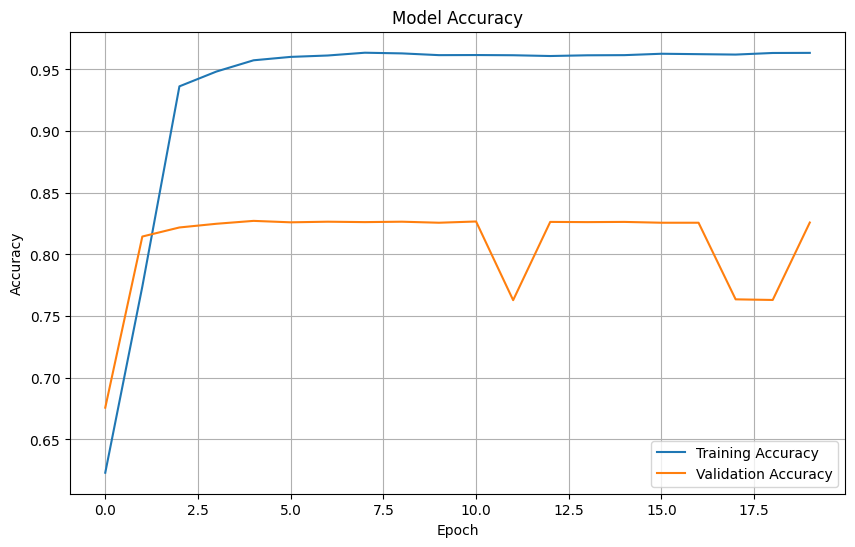

In [179]:
# Plot akurasi
plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

In [181]:
def predict_new_word(new_word):
    new_word_seq = tokenizer.texts_to_sequences([new_word])
    new_word_seq = np.array(new_word_seq)  # Convert to numpy array
    prediction = model.predict(new_word_seq)
    print(prediction)
    label = 'jamid' if prediction[0] >= 0.5 else 'musytaq'
    return label

# Contoh penggunaan
new_word = "مفتح"
label = predict_new_word(new_word)
print(f"Kata '{new_word}' dikenali sebagai: {label}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
[[0.4882092]]
Kata 'مفتح' dikenali sebagai: musytaq


In [186]:
model.save('jamid_musytaq_modelv2.h5')
print("Model telah disimpan ke 'jamid_musytaq_model.h5'")

Model telah disimpan ke 'jamid_musytaq_model.h5'


In [187]:
import joblib
with open('tokenizerv2.pkl', 'wb') as f:
    joblib.dump(tokenizer, f)
print("Tokenizer telah disimpan ke 'tokenizer.pkl'")

Tokenizer telah disimpan ke 'tokenizer.pkl'


# Test Model

In [14]:
tf.data.experimental.enable_debug_mode()
# Memuat model yang sudah disimpan
loaded_model = load_model('models/jamid_musytaq_model.h5')
# Memuat tokenizer yang sudah diunduh
with open('pipeline/tokenizerv2.pkl', 'rb') as f:
    tokenizer = joblib.load(f)

# Contoh penggunaan model yang dimuat untuk prediksi
@tf.function(reduce_retracing=True)
def predict_new_word(new_word):
    new_word_seq = tokenizer.texts_to_sequences([new_word])
    prediction = loaded_model.predict(new_word_pad)
    label = 'jamid' if prediction[0] >= 0.5 else 'musytaq'
    return label

# Contoh penggunaan
new_word = "مَعْلُوم"
label = predict_new_word(new_word)
print(f"Kata '{new_word}' dikenali sebagai: {label}")

NameError: in user code:

    File "C:\Users\dzak\AppData\Local\Temp\ipykernel_4812\4273796826.py", line 12, in predict_new_word  *
        prediction = loaded_model.predict(new_word_pad)

    NameError: name 'new_word_pad' is not defined


In [54]:

# Memuat model yang sudah disimpan
loaded_model = load_model('models/jamid_musytaq_modelv2.h5')
# Memuat tokenizer yang sudah diunduh
with open('pipeline/tokenizerv2.pkl', 'rb') as f:
    tokenizer = joblib.load(f)

# Contoh penggunaan model yang dimuat untuk prediksi

def predict_new_word(new_word):
    new_word_seq = tokenizer.texts_to_sequences([new_word])
    new_word_seq = np.array(new_word_seq)  # Convert to numpy array
    prediction = loaded_model.predict(new_word_seq)
    label = 'jamid' if prediction[0] >= 0.5 else 'musytaq'
    return label

# Contoh penggunaan
new_word = "سقط"
label = predict_new_word(new_word)
print(f"Kata '{new_word}' dikenali sebagai: {label}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Kata 'سقط' dikenali sebagai: jamid
